First improvement from preliminary: Having an overall setting script, containing the various imports to run the scikit-allel analysis.

In [1]:
%run ../scripts/notebook_settings.py

Using my newly created metadata

In [2]:
meta_data_samples = pd.read_table("../data/metadata_with_x_missing.txt", sep=" ")

Picking the IDs to run the X PCA on

In [3]:
IDs = meta_data_samples.loc[(meta_data_samples.Sex == "F")].callset_index.values
meta_data_samples.loc[meta_data_samples.callset_index.isin(IDs)]

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index,C_origin,x_missing
0,16066,16066_3130,Rogers,Papio,cynocephalus,"Mikumi, Tanzania",F,"Mikumi, Kilosa, Morogoro, Coastal Zone, Tanzania",36.977032,-7.404852,0,"Cynocephalus, Central Tanzania",0.013908
1,16098,16098_5026,Rogers,Papio,cynocephalus,"Mikumi, Tanzania",F,"Mikumi, Kilosa, Morogoro, Coastal Zone, Tanzania",36.977032,-7.404852,1,"Cynocephalus, Central Tanzania",0.013826
3,30977,30977_3373,James Else,Papio,anubis,"Aberdare, Kenya",F,"Aberdare National Park, Nyeri, Central Kenya, ...",36.712451,-0.410251,3,"Anubis, Kenya",0.009998
4,34449,34449_BZ11022,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,4,"Kindae, Zambia",0.013498
5,34474,34474_BZ11050,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,5,"Kindae, Zambia",0.013767
...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,PD_0788,34413_BZ11060,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,220,"Kindae, Zambia",0.010075
221,PD_0789,34417_BZ11064,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,221,"Kindae, Zambia",0.010196
222,PD_0790,34418_BZ11065,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,222,"Kindae, Zambia",0.009835
223,PD_0791,34419_BZ11066,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,223,"Kindae, Zambia",0.009672


Reading from the x_chr vcf

In [4]:
zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/chrX"
#Opening the zarr data
callset = zarr.open_group(zarr_dir, mode="r")
gt = allel.GenotypeArray(callset["calldata/GT"])

Functions to run the PCA, first two from http://alimanfoo.github.io/2015/09/28/fast-pca.html 

In [64]:
def plot_ld(gn, title):
    m = allel.rogers_huff_r(gn) ** 2
    ax = allel.plot_pairwise_ld(m)
    ax.set_title(title)

def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

def offset_legend(fig):
    ax = fig.add_subplot(111)
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='best', bbox_to_anchor=(1,1))
    return lgd

def pruning_and_pca(gt, IDs, subsampling_n, size, n_iter, n_components=10):
    print("Investigating {} individuals".format(len(IDs)))
    gt = gt.take(IDs, axis=1)
    ac = gt.count_alleles()[:] #Allele counts for each pos
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1) #Filtering for biallelic 
    #and at least two individuals in the alt state
    gf = gt.compress(flt, axis=0) #Applying filter
    gn = gf.to_n_alt() #Transform genotype to number of non-ref alleles
    if subsampling_n > len(gn):
        subsampling_n = len(gn)-1
    vidx = np.random.choice(gn.shape[0], subsampling_n, replace=False) #Random subsampling
    vidx.sort()
    gnr = gn.take(vidx, axis=0) #Applying the random subsample
    gnu = ld_prune(gnr, size=size, step=200, threshold=.1, n_iter=n_iter) #Pruning based on LD
    if len(gnu) > 150000:
        print("Too large dataset for pca")
        return "Too large dataset for pca"
    gnu = gnu[:] #Taking it out of chunked storage
    coords1, model1 = allel.pca(gnu, n_components=n_components, scaler='patterson') #Running the pca
    #The plotting solution in the example is inflexible, so I will try to make it through seaborn.
    pca_df = pd.DataFrame()
    c_transposed = coords1.transpose()
    for i in range(len(c_transposed)):
        pc = "pc{}".format(i+1)
        pca_df[pc] = c_transposed[i]
    pca_df["callset_index"] = IDs
    pca_df_meta = pd.merge(pca_df, meta_data_samples)
    if n_components == 10:
        fig, ax = plt.subplots()
        sns.despine(ax=ax)
        x = np.arange(10)
        y = model1.explained_variance_ratio_ * 100
        ax.bar(x+.6, y, width=.8)
        ax.set_xticks(x+1)
        ax.set_xlim(0, 11)
        ax.set_xlabel('component')
        ax.set_ylabel('% variance explained')
    return pca_df_meta

Running the PCA. Inputs: The zarr, the IDs to collect. 
The first int depicts number of sites to randomly sample.
The second depicts the window to calculate LD for.
The third depicts the number of times to LD_prune.

Investigating 227 individuals
iteration 1 retaining 262317 removing 2297869 variants
iteration 2 retaining 54955 removing 207362 variants


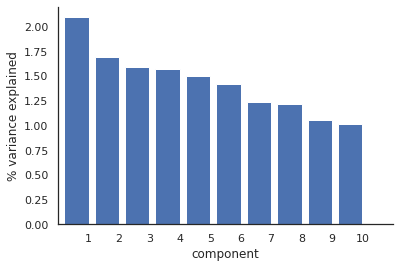

In [6]:
IDs = meta_data_samples.callset_index.values
pca_df = pruning_and_pca(gt, IDs, 3000000, 500, 2)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


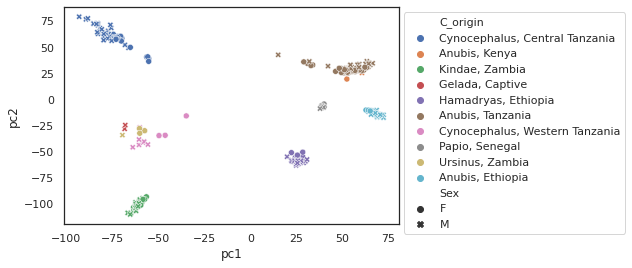

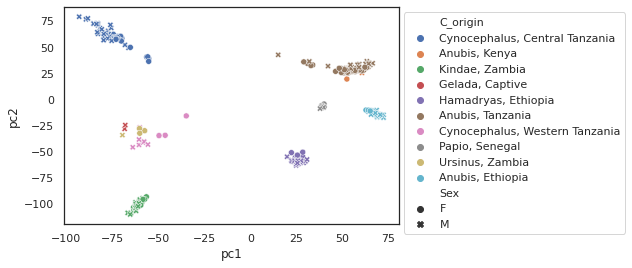

In [7]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="C_origin", style="Sex")
fig_males = scatter_sns.get_figure()
lgd = offset_legend(fig_males)
fig_males.savefig("../results/pca_x_with_males", bbox_extra_artists=[lgd], bbox_inches='tight')
fig_males

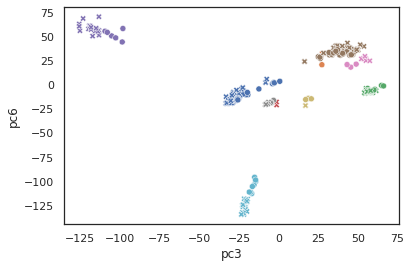

In [8]:
scatter_sns = sns.scatterplot(data = pca_df, x="pc3", y="pc6", hue="C_origin", style="Sex")
scatter_sns.legend([],[], frameon=False)

With all individuals, the captive geladas dominate pc4, papio dominate pc5, so the most informative pcs beyond 1/2 are 3/6.

Loading the sites to keep, which I created in dp03

In [9]:
masked_sites = np.load("../data/kept_pos_x_female.npy")
gt_masked_sites = gt.take(masked_sites, axis=0)

Investigating 98 individuals
iteration 1 retaining 90745 removing 1446897 variants
iteration 2 retaining 9577 removing 81168 variants


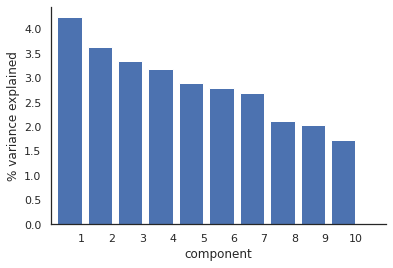

In [10]:
IDs = meta_data_samples.loc[(meta_data_samples.x_missing <= 0.015)
                             & (meta_data_samples.Sex == "F")
                             & (meta_data_samples.C_origin != "Anubis, Kenya")].callset_index.values
pca_df = pruning_and_pca(gt_masked_sites, IDs, 3000000, 500, 2)

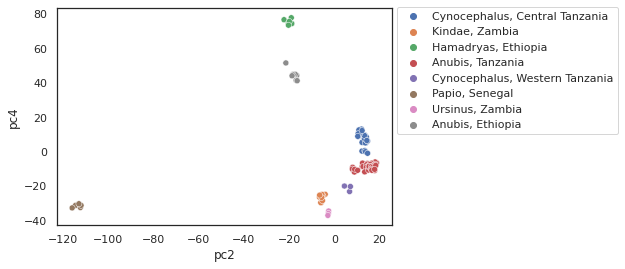

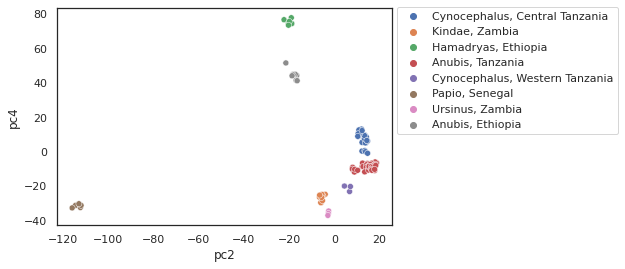

In [11]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc2", y="pc4", hue="C_origin")
fig_females = scatter_sns.get_figure()
scatter_sns.legend(bbox_to_anchor=(1., 1.03, 0., 0))
fig_females.savefig("../results/pca_x_females", bbox_extra_artists=[lgd], bbox_inches='tight')
fig_females

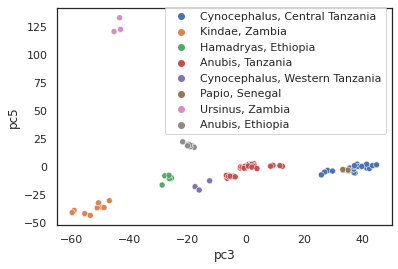

In [12]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc3", y="pc5", hue="C_origin")
fig_females = scatter_sns.get_figure()
scatter_sns.legend(bbox_to_anchor=(1., 1.03, 0., 0))

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


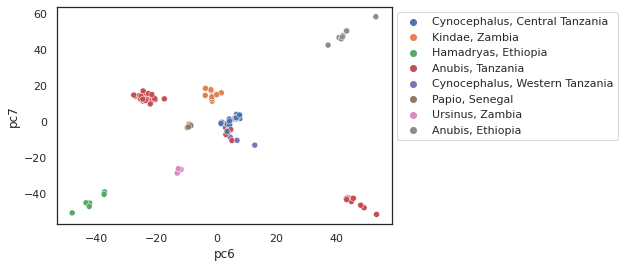

In [13]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc6", y="pc7", hue="C_origin")
fig_females = scatter_sns.get_figure()
lgd = offset_legend(fig_females)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


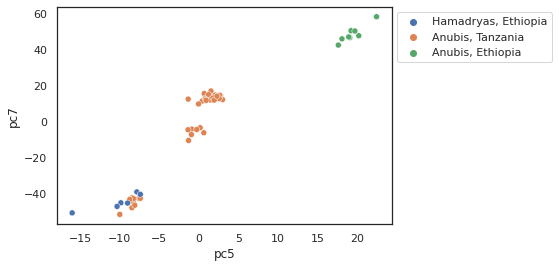

In [14]:
plt.close()
pca_df_subset = pca_df.loc[(pca_df.Species == "anubis") | (pca_df.Species == "hamadryas")]
scatter_sns = sns.scatterplot(data = pca_df_subset, x="pc5", y="pc7", hue="C_origin")
fig_females = scatter_sns.get_figure()
lgd = offset_legend(fig_females)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


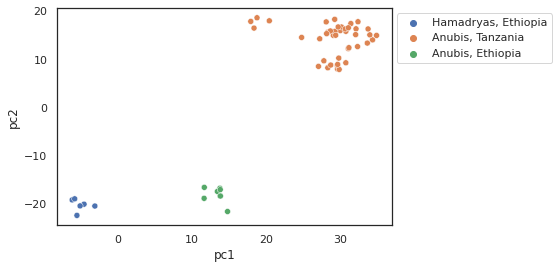

In [15]:
plt.close()
pca_df_subset = pca_df.loc[(pca_df.Species == "anubis") | (pca_df.Species == "hamadryas")]
scatter_sns = sns.scatterplot(data = pca_df_subset, x="pc1", y="pc2", hue="C_origin")
fig_females = scatter_sns.get_figure()
lgd = offset_legend(fig_females)

Finding anubis, Tanzania females which seem to be the least admixed.

In [16]:
a_tan = pca_df.loc[pca_df.C_origin == "Anubis, Tanzania"]
a_tan #43 Anubis Tanzania females.

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,C_origin,x_missing
5,31.095047,12.244868,-1.993906,-8.585969,-0.914398,3.701664,-4.097876,-1.088177,-57.493736,2.275216,...,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,"Anubis, Tanzania",0.003591
6,31.183550,12.430620,-1.855412,-6.613864,0.148880,3.059436,-3.317007,-4.340823,-69.164009,-2.801532,...,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,"Anubis, Tanzania",0.004100
7,32.347984,12.652008,-0.407561,-8.613864,-1.382398,3.939289,-4.495265,-1.214929,-60.900356,1.529756,...,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,"Anubis, Tanzania",0.003674
8,30.019808,15.973235,2.709910,-8.163235,2.977345,-20.406507,12.358908,2.131583,1.704674,-5.540813,...,Knauf/Chuma/Roos,Papio,anubis,"Arusha, Tanzania",F,"Arusha, Northern Zone, Tanzania",36.708585,-3.427534,"Anubis, Tanzania",0.004107
9,24.796629,14.547684,1.525582,-6.850653,2.012132,-17.387100,12.753314,2.597074,0.809185,-5.813966,...,Knauf/Chuma/Roos,Papio,anubis,"Arusha, Tanzania",F,"Arusha, Northern Zone, Tanzania",36.708585,-3.427534,"Anubis, Tanzania",0.004304
10,29.067574,14.984066,0.919589,-8.510485,1.569269,-21.944466,12.274709,3.848765,7.182008,5.379433,...,Knauf/Chuma/Roos,Papio,anubis,"Ngorongoro, Tanzania",F,"Ngorongoro, Arusha, Northern Zone, Tanzania",35.585946,-2.676953,"Anubis, Tanzania",0.004139
11,29.300383,15.805616,1.396419,-8.182831,1.953473,-24.683567,12.370418,0.936923,8.874959,6.158249,...,Knauf/Chuma/Roos,Papio,anubis,"Ngorongoro, Tanzania",F,"Ngorongoro, Arusha, Northern Zone, Tanzania",35.585946,-2.676953,"Anubis, Tanzania",0.004082
12,30.166431,16.712122,1.932568,-8.793207,2.034374,-26.986170,14.282601,1.206954,14.489561,10.218204,...,Knauf/Chuma/Roos,Papio,anubis,"Ngorongoro, Tanzania",F,"Ngorongoro, Arusha, Northern Zone, Tanzania",35.585946,-2.676953,"Anubis, Tanzania",0.004797
13,30.835260,16.200306,1.322422,-9.630810,2.038012,-27.578514,14.884752,2.587519,19.930775,17.622566,...,Knauf/Chuma/Roos,Papio,anubis,"Ngorongoro, Tanzania",F,"Ngorongoro, Arusha, Northern Zone, Tanzania",35.585946,-2.676953,"Anubis, Tanzania",0.005160
14,28.326880,15.635287,0.998731,-8.365206,0.826065,-23.339321,11.959669,1.709090,15.396935,10.483335,...,Knauf/Chuma/Roos,Papio,anubis,"Ngorongoro, Tanzania",F,"Ngorongoro, Arusha, Northern Zone, Tanzania",35.585946,-2.676953,"Anubis, Tanzania",0.004239


In [17]:
a_tan.loc[(a_tan.pc1 > 24) & (a_tan.pc3 > 0) & (a_tan.pc3 < 7) & (a_tan.pc7 > -5)].PGDP_ID.values

array(['PD_0205', 'PD_0206', 'PD_0208', 'PD_0209', 'PD_0210', 'PD_0211',
       'PD_0212', 'PD_0238', 'PD_0239', 'PD_0240', 'PD_0241', 'PD_0492',
       'PD_0674', 'PD_0675', 'PD_0676', 'PD_0677', 'PD_0678', 'PD_0680',
       'PD_0682', 'PD_0683', 'PD_0685', 'PD_0686'], dtype=object)

Investigating 90 individuals
iteration 1 retaining 88777 removing 1408241 variants
iteration 2 retaining 13077 removing 75700 variants


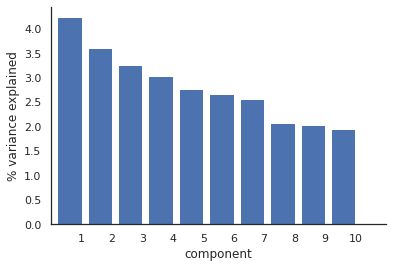

In [18]:
IDs = meta_data_samples.loc[(meta_data_samples.x_missing <= 0.01)
                             & (meta_data_samples.Sex == "F")].callset_index.values
pca_df = pruning_and_pca(gt, IDs, 3000000, 500, 2)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


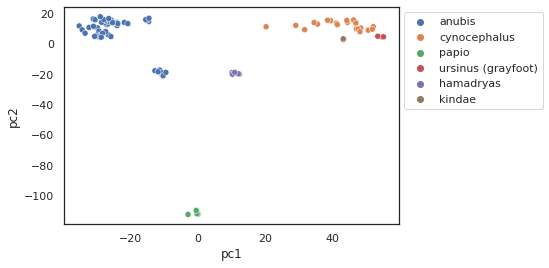

In [19]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="Species")
fig_females = scatter_sns.get_figure()
lgd = offset_legend(fig_females)

Taking 5, which are of speices Cynocephalus, Central Tanzania
Taking 0, which are of speices Anubis, Kenya
Taking 3, which are of speices Kindae, Zambia
Taking 0, which are of speices Gelada, Captive
Taking 5, which are of speices Hamadryas, Ethiopia
Taking 5, which are of speices Anubis, Tanzania
Taking 3, which are of speices Cynocephalus, Western Tanzania
Taking 0, which are of speices Papio, Senegal
Taking 3, which are of speices Ursinus, Zambia
Taking 5, which are of speices Anubis, Ethiopia
Investigating 29 individuals
iteration 1 retaining 32580 removing 1061964 variants
iteration 2 retaining 1432 removing 31148 variants


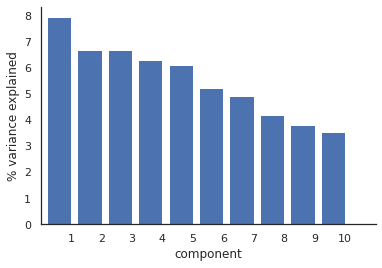

In [20]:
#Only taking 5 individuals per cluster.
females = meta_data_samples.loc[(meta_data_samples.Sex == "F") 
                                & (meta_data_samples.x_missing <= 0.01)
                                & (meta_data_samples.Species != "papio")
                                & (meta_data_samples.C_origin != "Anubis, Kenya")]
IDs = []

for cluster in meta_data_samples.C_origin.unique():
    cluster_IDs = females.loc[females.C_origin == cluster]
    n = min(5, len(cluster_IDs))
    print("Taking {}, which are of speices {}".format(n, cluster))
    IDs.extend(np.random.choice(cluster_IDs.callset_index.values, n, replace=False))
pca_df = pruning_and_pca(gt_masked_sites, IDs, 3000000, 500, 2)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


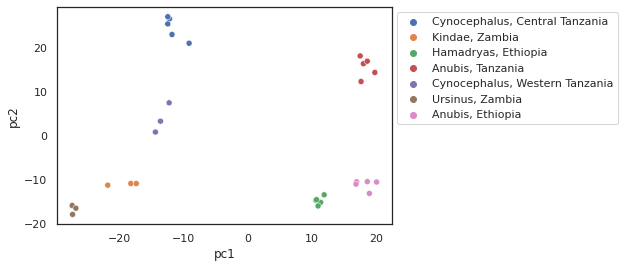

In [21]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="C_origin")
fig_females = scatter_sns.get_figure()
lgd = offset_legend(fig_females)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


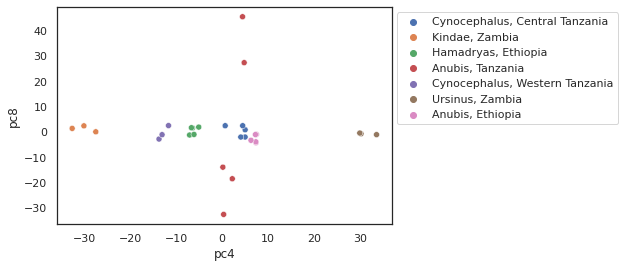

In [22]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc4", y="pc8", hue="C_origin")
fig_females = scatter_sns.get_figure()
lgd = offset_legend(fig_females)

Trying out UMAP

In [23]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [24]:
import umap
reducer = umap.UMAP()

In [25]:
IDs = meta_data_samples.loc[(meta_data_samples.x_missing <= 0.01)
                             & (meta_data_samples.Sex == "F")].callset_index.values

In [65]:
pca_df = pruning_and_pca(gt, IDs, 3000000, 500, 2, n_components=20)

Investigating 90 individuals
iteration 1 retaining 88780 removing 1408238 variants
iteration 2 retaining 13146 removing 75634 variants


In [67]:
pca_df.iloc[:,:15]

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15
0,-26.984066,2.669461,12.627889,-2.108920,2.771046,-10.158531,4.764434,-97.684914,11.924277,-173.867813,5.817968,-5.132798,-21.268534,1.170671,-8.159212
1,-29.214497,7.202922,-3.001505,4.246001,0.815766,-0.384708,-5.209565,-52.791035,-7.405646,19.011753,2.472167,-0.821492,13.062614,16.912054,20.878820
2,-27.444845,5.901859,-0.841211,2.578162,2.136768,-3.299410,-2.239786,-56.990528,-5.788596,37.299072,-1.496131,-7.800541,3.638632,7.111075,3.381793
3,-30.011408,7.848525,-1.553232,3.388995,-1.054750,-1.253660,-1.534060,-51.663433,-2.933278,25.898222,0.036434,-2.933490,13.696500,12.942724,12.978065
4,-23.257107,14.367338,-6.771422,1.158703,-17.215357,-7.831137,7.338235,-6.406226,1.665398,-7.494220,0.873729,24.591171,110.099258,-35.945080,-20.935896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,47.580498,11.680073,-14.667620,-30.777380,6.518537,-7.914361,-5.553255,-3.701133,-21.409105,0.525344,14.170544,1.661280,-1.681217,1.702678,2.113393
86,47.398464,10.957278,-15.231949,-29.017635,6.506938,-8.580308,-5.089862,-2.599648,-15.579720,-1.370258,10.592371,1.553659,-2.907335,0.981479,1.818225
87,49.612316,14.183773,-16.810314,-34.057732,4.614461,-10.464552,-6.810958,-3.457455,-28.557674,-3.795684,26.744724,5.529696,-3.674644,-0.170829,-2.046762
88,44.481956,5.075780,18.099554,61.011875,5.513345,46.466534,78.455261,-3.624565,-55.224079,-4.126947,-20.764301,-0.635610,1.286911,3.729452,0.049452


In [68]:
reducer = umap.UMAP(random_state=42)
reducer.fit(pca_df.iloc[:,:20])

UMAP(random_state=42)

In [70]:
embedding = reducer.transform(pca_df.iloc[:,:20])

In [71]:
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(90, 2)

In [72]:
embedding_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])

In [73]:
meta_data_samples.loc[(meta_data_samples.x_missing <= 0.01)
                             & (meta_data_samples.Sex == "F")].reset_index()

,index,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index,C_origin,x_missing
0,3,30977,30977_3373,James Else,Papio,anubis,"Aberdare, Kenya",F,"Aberdare National Park, Nyeri, Central Kenya, ...",36.712451,-0.410251,3,"Anubis, Kenya",0.009998
1,10,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,10,"Anubis, Tanzania",0.003591
2,11,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,11,"Anubis, Tanzania",0.004100
3,14,PD_0203,21SNF1151115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,14,"Anubis, Tanzania",0.003674
4,16,PD_0205,05ANF1030116,Knauf/Chuma/Roos,Papio,anubis,"Arusha, Tanzania",F,"Arusha, Northern Zone, Tanzania",36.708585,-3.427534,16,"Anubis, Tanzania",0.004107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,204,PD_0772,16006_2008,Rogers,Papio,cynocephalus,"Mikumi, Tanzania",F,"Mikumi, Kilosa, Morogoro, Coastal Zone, Tanzania",36.977032,-7.404852,204,"Cynocephalus, Central Tanzania",0.008772
86,205,PD_0773,16008_2010,Rogers,Papio,cynocephalus,"Mikumi, Tanzania",F,"Mikumi, Kilosa, Morogoro, Coastal Zone, Tanzania",36.977032,-7.404852,205,"Cynocephalus, Central Tanzania",0.008856
87,206,PD_0774,16035_3003,Rogers,Papio,cynocephalus,"Mikumi, Tanzania",F,"Mikumi, Kilosa, Morogoro, Coastal Zone, Tanzania",36.977032,-7.404852,206,"Cynocephalus, Central Tanzania",0.009476
88,222,PD_0790,34418_BZ11065,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,222,"Kindae, Zambia",0.009835


In [74]:
UMAP_df = pd.concat([embedding_df, meta_data_samples.loc[(meta_data_samples.x_missing <= 0.01)
                             & (meta_data_samples.Sex == "F")].reset_index()], axis=1)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


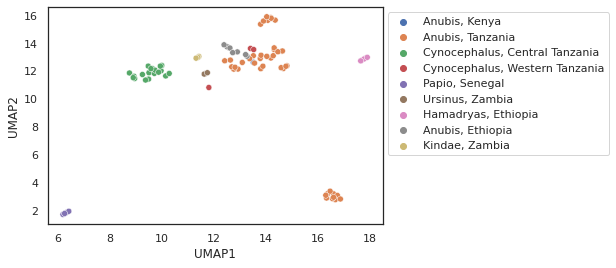

In [75]:
scatter_sns = sns.scatterplot(data = UMAP_df, x="UMAP1", y="UMAP2", hue="C_origin")
fig_females = scatter_sns.get_figure()
lgd = offset_legend(fig_females)